part init
checked
17.0099
38.634316
19.790735999999995
3.286736
0.635404
Early stopping at iteration 49 due to low variance in fitness values.


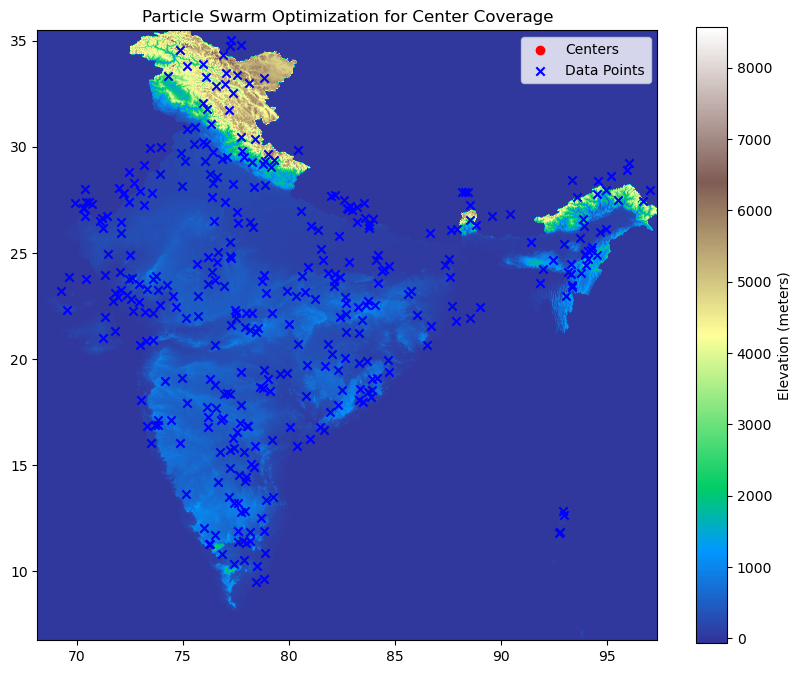

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.animation import FuncAnimation
from scipy.spatial import KDTree

# Function to convert DMS to decimal degrees
def dms_to_dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes / 60 + seconds / 3600
    if direction in ['S', 'W']:
        dd *= -1
    return dd

# Function to check if a point is within the given distance from another point using the Haversine formula
def covers(point, target, distance):
    return haversine(point, target) <= distance

# Function to calculate the Haversine distance between two points in kilometers
def haversine(coord1, coord2):
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Earth radius in kilometers
    r = 6371.0
    return r * c

def is_within_elevation_range(center, terrain_data, bounds):
    lat_index = int((center[0] - bounds[0]) / terrain_data.res[0])
    lon_index = int((center[1] - bounds[2]) / terrain_data.res[1])

    # Check if indices are within bounds
    if lat_index < 0 or lat_index >= terrain_data.shape[0] or lon_index < 0 or lon_index >= terrain_data.shape[1]:
        return False
    
    elevation = terrain_data.read(1)[lat_index, lon_index]
    return 0 <= elevation <= 2000

# Fitness function
def fitness(particle, data, distance, terrain_data, bounds):
    total_coverage = 0
    covered_points = set()
    for point in data:
        for center in particle:
            if covers(center, point, distance):
                total_coverage += 1
                covered_points.add(tuple(point))
                break
    return total_coverage, covered_points

def pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data, w=0.5, c1=1.5, c2=1.5, threshold=1.0):
    # Precompute bounds and elevation check parameters
    bounds_low = np.array([bounds[0], bounds[2]])
    bounds_high = np.array([bounds[1], bounds[3]])
    print("part init")
    def initialize_particles():
        particles = np.random.uniform(low=bounds_low, high=bounds_high, size=(num_particles, num_centers, 2))
        velocities = np.random.uniform(low=-1, high=1, size=(num_particles, num_centers, 2))
        for i in range(num_particles):
            for j in range(num_centers):
                while not is_within_elevation_range(particles[i, j], terrain_data, bounds):
                    particles[i, j] = np.random.uniform(low=bounds_low, high=bounds_high, size=2)
        return particles, velocities

    # Initialize particles
    particles, velocities = initialize_particles()

    # Initialize personal bests and global best
    p_best = particles.copy()
    p_best_fitness = np.zeros(num_particles)
    for i in range(num_particles):
        p_best_fitness[i], _ = fitness(p_best[i], data, distance, terrain_data, bounds)
    g_best_index = np.argmax(p_best_fitness)
    g_best = p_best[g_best_index].copy()
    g_best_fitness = p_best_fitness[g_best_index]
    g_best_covered = set()
    print("checked")
    # Initialize particle history and fitness history
    particle_history = [particles.copy()]
    fitness_history = []
    centers_list = []
    points_covered_list = []

    # PSO iterations
    for iteration in range(num_iterations):
        all_covered = False
        current_fitness_values = []

        for i in range(num_particles):
            # Update velocity
            velocities[i] = (w * velocities[i]
                             + c1 * np.random.rand() * (p_best[i] - particles[i])
                             + c2 * np.random.rand() * (g_best - particles[i]))
            # Update particle position
            particles[i] += velocities[i]
            # Boundary conditions
            particles[i] = np.clip(particles[i], bounds_low, bounds_high)

            # Ensure particles are within the elevation range
            for j in range(num_centers):
                if not is_within_elevation_range(particles[i, j], terrain_data, bounds):
                    particles[i, j] = np.random.uniform(low=bounds_low, high=bounds_high, size=2)

            # Update personal best
            current_fitness, current_covered = fitness(particles[i], data, distance, terrain_data, bounds)
            current_fitness_values.append(current_fitness)
            if current_fitness > p_best_fitness[i]:
                p_best[i] = particles[i].copy()
                p_best_fitness[i] = current_fitness

                # Update global best
                if current_fitness > g_best_fitness:
                    g_best = particles[i].copy()
                    g_best_fitness = current_fitness
                    g_best_covered = current_covered.copy()
                    
                    # Check if all points are covered
                    if len(g_best_covered) == len(data):
                        all_covered = True

        # Store particle positions for animation
        particle_history.append(particles.copy())
        fitness_history.append(current_fitness_values)
        
        # Terminate early if all points are covered
        if all_covered:
            break

        # Early stopping criterion based on variance of fitness values for the last 10 iterations
        if iteration >= 9 and iteration % 10 == 9:
            last_10_fitness_values = [fitness_history[-j][i] for j in range(1, 11) for i in range(num_particles)]
            fitness_variance = np.var(last_10_fitness_values)
            print(fitness_variance)
            if fitness_variance < threshold:
                print(f"Early stopping at iteration {iteration} due to low variance in fitness values.")
                break

    # Return the best particles, best fitness, and particle history
    return g_best, g_best_fitness, g_best_covered, particle_history, centers_list, points_covered_list

# Load the data from CSV
csv_path = "/Users/parasdhiman/Desktop/DRDO/random_points_inside.csv"
df = pd.read_csv(csv_path)
data = df[['Latitude', 'Longitude']].values

# Load the shapefile to get India boundary
shapefile_path = "/Users/parasdhiman/Desktop/DRDO/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"
gdf = gpd.read_file(shapefile_path)
india = gdf[gdf['NAME'] == 'India']

# Get bounds from the India shapefile
bounds = india.total_bounds  # bounds in the form (minx, miny, maxx, maxy)
bounds = [bounds[1], bounds[3], bounds[0], bounds[2]]  # convert to (miny, maxy, minx, maxx)

# Load the terrain data
tiff_path = "/Users/parasdhiman/Desktop/DRDO/india_clipped.tif"
terrain_data = rasterio.open(tiff_path)

# Define the PSO parameters
num_particles = 50  # Number of particles in the swarm
num_iterations = 100  # Number of iterations to run the PSO
num_centers = 10  # Number of centers to find
distance = 50  # Coverage distance in kilometers

# Find the best centers using PSO
best_points, _, _, particle_history, centers_list, points_covered_list = pso(data, bounds, distance, num_particles, num_iterations, num_centers, terrain_data)

# Animation setup
fig, ax = plt.subplots(figsize=(10, 8))
terrain_image = ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')
cbar = plt.colorbar(terrain_image, ax=ax)
cbar.set_label('Elevation (meters)')
ax.set_title('Particle Swarm Optimization for Center Coverage')
scat = ax.scatter([], [], color='red', marker='o', label='Centers')
ax.scatter(data[:, 1], data[:, 0], color='blue', marker='x', label='Data Points')
ax.legend()

def init():
    scat.set_offsets([])
    return scat,

def update(frame):
    ax.clear()
    ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')
    ax.scatter(data[:, 1], data[:, 0], c='white', label='Points')
    
    particles = particle_history[frame]
    for particle in particles:
        ax.scatter(particle[:, 1], particle[:, 0], c='red')
    
    centers_list.append(best_points)
    points_covered_list.append(fitness(best_points, data, distance, terrain_data, bounds)[1])

    return scat,

ani = FuncAnimation(fig, update, frames=len(particle_history), init_func=init, blit=False)

plt.show()


In [9]:
import pickle

# Define the file path to save the parameters
param_file_path = 'pso_params_India.pkl'


# Save the parametric information
with open(param_file_path, 'wb') as f:
    pickle.dump({
        'particle_history': particle_history,
        'bounds': bounds,
        'data': data,
        'best_points': centers_list,
        'distance': distance
    }, f)

/Users/parasdhiman/opt/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


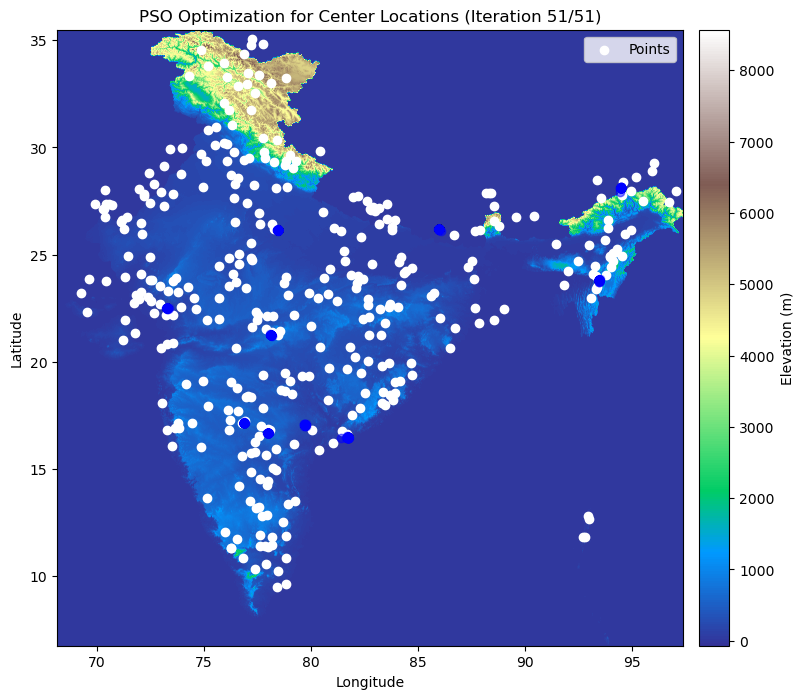

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from matplotlib.animation import FuncAnimation
import pickle

# Define the file path to load the parameters
param_file_path = 'pso_params_India.pkl'

# Load the parametric information
with open(param_file_path, 'rb') as f:
    params = pickle.load(f)

particle_history = params['particle_history']
bounds = params['bounds']
data = params['data']
best_points = params['best_points']
distance = params['distance']

# Load the terrain data
terrain_file = "/Users/parasdhiman/Desktop/DRDO/india_clipped.tif"  # Replace with your actual file path
terrain_data = rasterio.open(terrain_file)

# Create animation
fig, ax = plt.subplots(figsize=(10, 8))

# Show the terrain data with custom elevation-based colormap
terrain_image = ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')

# Add color bar for elevation
cbar = plt.colorbar(terrain_image, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Elevation (m)')

def update(frame):
    ax.clear()
    ax.imshow(terrain_data.read(1), extent=[bounds[2], bounds[3], bounds[0], bounds[1]], cmap='terrain', origin='upper')
    ax.scatter(data[:, 1], data[:, 0], c='white', label='Points')

    particles = particle_history[frame]
    for particle in particles:
        ax.scatter(particle[:, 1], particle[:, 0], c='blue', alpha=0.5)

    if frame == len(particle_history) - 1:
        for center in best_points:
            ax.scatter(center[1], center[0], c='red', marker='x', s=100, label='Center')
            circle = plt.Circle((center[1], center[0]), distance / 111, color='blue', fill=False)
            ax.add_artist(circle)

    ax.set_xlim(bounds[2], bounds[3])
    ax.set_ylim(bounds[0], bounds[1])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'PSO Optimization for Center Locations (Iteration {frame + 1}/{len(particle_history)})')

    cbar.set_label('Elevation (m)')

    ax.legend()

# Animate the PSO process
ani = FuncAnimation(fig, update, frames=len(particle_history), interval=200)
ani.save('pso_optimization_india.mp4', writer='ffmpeg', fps=10) 

# Show the animation
# plt.show()

